## LANL Earthquake Prediction (Kaggle Competition)
### Can you predict upcoming laboratory earthquakes?

Forecasting earthquakes is one of the most important problems in Earth science because of their devastating consequences. Current scientific studies related to earthquake forecasting focus on three key points: when the event will occur, where it will occur, and how large it will be.

In this competition, you will address when the earthquake will take place. Specifically, you’ll predict the time remaining before laboratory earthquakes occur from real-time seismic data.

If this challenge is solved and the physics are ultimately shown to scale from the laboratory to the field, researchers will have the potential to improve earthquake hazard assessments that could save lives and billions of dollars in infrastructure.

This challenge is hosted by Los Alamos National Laboratory which enhances national security by ensuring the safety of the U.S. nuclear stockpile, developing technologies to reduce threats from weapons of mass destruction, and solving problems related to energy, environment, infrastructure, health, and global security concerns.

### Step 1 :  Install Dependencies.

In [0]:
#To Access Kaggle Datasets
!pip install kaggle
!pip install numpy==1.15.0
!pip install catboost

### Step 2 :   Import Dependencies.

In [0]:
#Importing Dependecies For The Project.
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR
from sklearn.kernel_ridge import KernelRidge
import matplotlib.pyplot as plt

### Step 3 :   Import And Change Permission For Kaggle JSON File.

In [0]:
#Colab files access:
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#moving and changing permission of the files.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [0]:
#Lisitng Competitions Via Kaggle API.
!kaggle competitions list

ref                                            deadline             category            reward  teamCount  userHasEntered  
---------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2559           False  
titanic                                        2030-01-01 00:00:00  Getting Started  Knowledge      10275           False  
house-prices-advanced-regression-techniques    2030-01-01 00:00:00  Getting Started  Knowledge       4056           False  
imagenet-object-localization-challenge         2029-12-31 07:00:00  Research         Knowledge         36           False  
competitive-data-science-predict-future-sales  2019-12-31 23:59:00  Playground           Kudos       2560           False  
two-sigma-financial-news                       2019-07-15 23:59:00  Featured          $100,000       2927           False  
aerial-c

### Step 4 :   Downloading Required Project File.

In [0]:
#Downloading The Required Files For The Project Via Kaggle API.
!kaggle competitions download -c LANL-Earthquake-Prediction

  0% 0.00/33.3k [00:00<?, ?B/s]
100% 33.3k/33.3k [00:00<00:00, 14.0MB/s]
 96% 233M/242M [00:01<00:00, 176MB/s]
100% 242M/242M [00:01<00:00, 184MB/s]
100% 2.02G/2.03G [00:37<00:00, 54.6MB/s]
100% 2.03G/2.03G [00:37<00:00, 58.7MB/s]


In [0]:
!unzip train.csv.zip
!ls

Archive:  train.csv.zip
  inflating: train.csv               
sample_data  sample_submission.csv  test.zip  train.csv  train.csv.zip


In [0]:
!unzip test.zip

In [0]:
!ls -la | grep .csv

In [0]:
#Extracting Train Information into a Pandas Dataframe.
train  = pd.read_csv('train.csv', nrows=60000000, dtype={'acoustic_data': np.int16, 'time_to_failure':np.float64})

In [0]:
#printing a couple of data
train.head(15)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


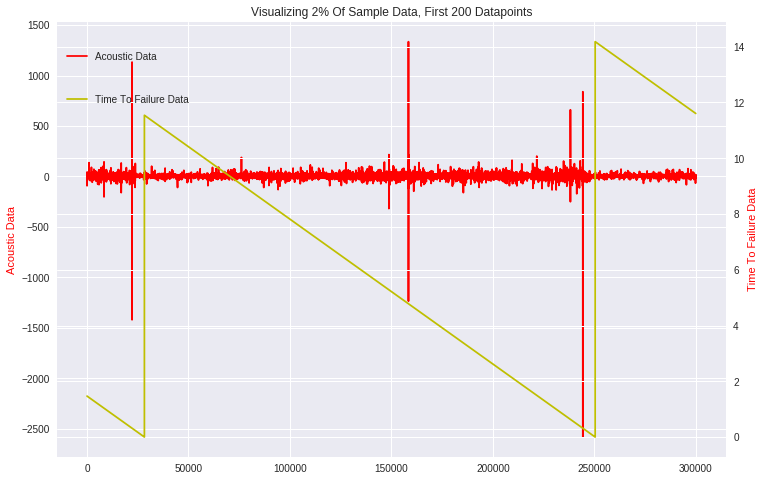

In [0]:
#visualize 2% of sample data, first 200 datapoints.
train_ad_vizsample_df = train['acoustic_data'].values[::200]
train_ttf_vizsample_df = train['time_to_failure'].values[::200]

#functionns for plotting based on based features

def plot_data(train_ad_vizsample_df, train_ttf_vizsample_df, title):
  fig, ax1 = plt.subplots(figsize=(12,8))
  plt.title(title)
  plt.plot(train_ad_vizsample_df, color='r')
  ax1.set_ylabel('Acoustic Data', color='r')
  plt.legend(['Acoustic Data'], loc=(0.01, 0.90))
  ax2 = ax1.twinx()
  plt.plot(train_ttf_vizsample_df, color='y')
  ax2.set_ylabel('Time To Failure Data', color='r')
  plt.legend(['Time To Failure Data'], loc=(0.01, 0.80))
  plt.grid(True)
  
title = 'Visualizing 2% Of Sample Data, First 200 Datapoints'
plot_data(train_ad_vizsample_df, train_ttf_vizsample_df, title)
del train_ttf_vizsample_df
del train_ad_vizsample_df
  

In [0]:
'''
The Questio we need to ask is the iterval constant, do ay other factors are involved using exploratory data analysis.

We notice a correlation betwee occurence of a instance of acoustic data just before time to failure. This seem to be evident with
the EDA performed above on 2% o the data to show the hypothesis of the relation.
'''

In [0]:
#Step 4 : Feature Engineering
#function to geerate some statistical feature based
def generate_feature(x):
  strain = []
  strain.append(x.mean())
  strain.append(x.std())
  strain.append(x.min())
  strain.append(x.kurtosis())
  strain.append(x.skew())
  strain.append(np.quantile(x, 0.01))
  return pd.Series(strain)

#x_train.describe()

In [0]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150000, dtype={'acoustic_data': np.int16, 'time_to_failure':np.float64})

x_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
  ch = generate_feature(df['acoustic_data'])
  x_train = x_train.append(ch, ignore_index=True)
  y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))

In [0]:
#Describinng the X-Train Information.
x_train.describe()

,0,1,2,3,4,5
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,68.297997,0.125830,-11.224603
std,0.256049,8.503939,265.087984,70.532565,0.477901,14.106852
min,3.596313,2.802720,-5515.000000,0.648602,-4.091826,-336.000000
25%,4.349497,4.478637,-154.000000,28.090227,-0.040779,-14.000000
50%,4.522147,5.618798,-111.000000,45.816625,0.085620,-10.000000
75%,4.693350,6.880904,-79.000000,78.664202,0.253930,-6.000000
max,5.391993,153.703569,-15.000000,631.158927,4.219429,-2.000000


In [0]:
#Step 5 :  Implement CatBoost Model
train_pool = Pool(x_train,y_train)
m= CatBoostRegressor(iterations=10000, loss_function='MAE', boosting_type='Ordered')
m.fit(x_train,y_train, silent=True)

In [0]:
m.best_score_

{'learn': {'MAE': 1.8601300851030422}}